In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sqlalchemy import create_engine, MetaData, insert, select
from sqlalchemy.sql import and_
from sqlalchemy.orm import Session
from sqlalchemy.exc import IntegrityError, OperationalError
from sqlalchemy.pool import NullPool

# Load Data
Either load the data by querying the database, or if the query results have already been stored, then load it from the respective files instead.

## Load Data from Database
For first run of notebook, otherwise run block below that loads pre-saved query results instead

### Connect to Database

In [328]:
user = "cokk"

topsecretword = "8iCyrvxoK4RMitkZ"
# host = "lnx-cokk-1.lunet.lboro.ac.uk"
host = "localhost"
db_name = "run2"

engine = create_engine(
    f"mysql://{user}:{topsecretword}@{host}/{db_name}?charset=utf8mb4",
    isolation_level="SERIALIZABLE",
    poolclass=NullPool,
)

meta_data = MetaData()
meta_data.reflect(engine)

### Query Database

In [721]:
# For each combination of experiment parameters, get various statistics such as number of wins (any guess or 0-guess),
# samples considered, and decision times

statement = """
    SELECT difficulty_id, sample_width, sample_height, use_mine_count, first_click_always_zero, can_flag,
            SUM(CASE WHEN num_guesses=0 AND win=1 THEN 1 ELSE 0 END) AS wins_0_guess, SUM(win) AS wins,
            COUNT(*) AS num_games
    FROM grid
    JOIN game on grid.id=game.grid_id
    JOIN difficulty ON difficulty.id=grid.difficulty_id
    GROUP BY difficulty_id, sample_width, sample_height, use_mine_count, first_click_always_zero, can_flag;
"""
# statement = """
#     SELECT difficulty_id, sample_width, sample_height, use_mine_count, first_click_always_zero, can_flag,
#             SUM(CASE WHEN num_guesses=0 AND win=1 THEN 1 ELSE 0 END) AS wins_0_guess, SUM(win) AS wins,
#             COUNT(*) AS num_games, SUM(samples_considered) AS total_samples_considered,
#             AVG(seconds_to_decide_move) AS avg_decision_time, AVG(sps_seconds_elapsed) AS avg_sps_time,
#             AVG(brute_seconds_elapsed) AS avg_brute_time
#     FROM grid
#     JOIN game on grid.id=game.grid_id
#     JOIN difficulty ON difficulty.id=grid.difficulty_id
#     JOIN turn ON turn.game_id=game.id
#     JOIN sample ON sample.turn_id=turn.id
#     GROUP BY difficulty_id, sample_width, sample_height, use_mine_count, first_click_always_zero, can_flag;
# """
df = pd.read_sql_query(statement, engine)
df

,difficulty_id,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games
0,1,4,4,0,1,1,9475.0,12544.0,15000
1,1,4,4,1,1,1,10070.0,12683.0,15000
2,1,4,4,0,0,1,2954.0,9491.0,15000
3,1,5,5,1,1,1,10422.0,12798.0,15000
4,1,4,4,1,0,1,3131.0,9598.0,15000
...,...,...,...,...,...,...,...,...,...
211,4,32,18,0,1,0,1479.0,4691.0,15000
212,4,9,9,1,1,0,1475.0,4683.0,15000
213,4,32,18,1,1,0,2199.0,5213.0,15000
214,4,10,10,0,1,0,1479.0,4690.0,15000


In [722]:
# Get difficulty details so that difficulty ids can be replaced with something more descriptive
statement = """
    SELECT *
    FROM difficulty;
"""
df_difficulty = pd.read_sql_query(statement, engine)
df_difficulty

,id,rows,columns,mines,name
0,1,8,8,10,Beginner (pre Windows 2000)
1,2,9,9,10,Beginner
2,3,16,16,40,Intermediate
3,4,16,30,99,Expert


In [723]:
# Get wins (any guess and 0-guess) for a specific combination of experiment parameters that is comparable with
# the other two external solvers and the results from the verification experiment.
statement = "SELECT difficulty_id, SUM(CASE WHEN num_guesses=0 AND win=1 THEN 1 ELSE 0 END) AS wins_0_guess, SUM(win) AS wins, COUNT(*) AS num_games FROM grid JOIN game on grid.id=game.grid_id JOIN difficulty ON difficulty.id=grid.difficulty_id WHERE first_click_always_zero=true AND use_mine_count=true AND can_flag=true AND sample_width >= columns AND sample_height >= difficulty.rows AND columns > 8 GROUP BY difficulty_id ORDER BY difficulty_id;"
df_solver_comparison = pd.read_sql_query(statement, engine)
df_solver_comparison

,difficulty_id,wins_0_guess,wins,num_games
0,2,13463.0,14413.0,15000
1,3,10521.0,12698.0,15000
2,4,2199.0,5213.0,15000


### Save Query Results

In [724]:
df.to_csv('query_main.csv', index=False)
df_difficulty.to_csv('query_difficulty.csv', index=False)
df_solver_comparison.to_csv('query_solver_comparison.csv', index=False)

## Load Data from Saved Query Results
Use if query results have already been saved into local files

In [4]:
df_main = pd.read_csv('query_main.csv')
df_difficulty = pd.read_csv('query_difficulty.csv')
df_solver_comparison = pd.read_csv('query_solver_comparison.csv')

In [5]:
df_main

,difficulty_id,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games
0,1,4,4,0,1,1,9475,12544,15000
1,1,4,4,1,1,1,10070,12683,15000
2,1,4,4,0,0,1,2954,9491,15000
3,1,5,5,1,1,1,10422,12798,15000
4,1,4,4,1,0,1,3131,9598,15000
...,...,...,...,...,...,...,...,...,...
211,4,32,18,0,1,0,1479,4691,15000
212,4,9,9,1,1,0,1475,4683,15000
213,4,32,18,1,1,0,2199,5213,15000
214,4,10,10,0,1,0,1479,4690,15000


In [6]:
df_difficulty

,id,rows,columns,mines,name
0,1,8,8,10,Beginner (pre Windows 2000)
1,2,9,9,10,Beginner
2,3,16,16,40,Intermediate
3,4,16,30,99,Expert


In [7]:
df_solver_comparison

,difficulty_id,wins_0_guess,wins,num_games
0,2,13463,14413,15000
1,3,10521,12698,15000
2,4,2199,5213,15000


# Pre-process Data

### Utility functions - replace difficulty id with difficulty information
E.g. Difficulty id 4 becomes "Expert 30x16x99"

In [8]:
def replace_difficulty_id_with_name(df_to_change, df_difficulty):
    # Change lengthy Beginner name. ASSUMING IT'S IN 0th INDEX!
    df_difficulty.loc[0, 'name'] = "Beginner"
    
    # Joins are based on index, so set index to attributes to join on
    df1 = df_to_change.set_index('difficulty_id')
    df2 = df_difficulty.set_index('id')
    
    df = df1.join(df2)
    df = df.reset_index(drop=True)
    
    # Create new column from name x rows x columns x mines columns
    df = concatenate_difficulty_columns(df)
    
    return df
    

def concatenate_difficulty_columns(original_df):
    # Append columns x rows x mines information to name of difficulty. 
    # E.g. Expert 30x16x99 means grid contains 30 columns and 16 rows, with 99 start mines
    
    # Don't want to accidentaly alter original
    df = original_df.copy()
    
    changed_names = df['name'] + ' ' + df['columns'].map(str) + 'x' + df['rows'].map(str) + 'x' + df['mines'].map(str) 
    df['difficulty'] = changed_names
    return df

### Create dataframes for analysis

In [9]:
# Copy so we don't alter the originals. Less chance of needing to re-query the database.
df1_copy = df_main.copy()
df2_copy = df_difficulty.copy()
df3_copy = df_solver_comparison.copy()

In [10]:
df_wins = replace_difficulty_id_with_name(df1_copy, df2_copy)
df_compare_solvers = replace_difficulty_id_with_name(df3_copy, df2_copy)
df_wins

,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games,rows,columns,mines,name,difficulty
0,4,4,0,1,1,9475,12544,15000,8,8,10,Beginner,Beginner 8x8x10
1,4,4,1,1,1,10070,12683,15000,8,8,10,Beginner,Beginner 8x8x10
2,4,4,0,0,1,2954,9491,15000,8,8,10,Beginner,Beginner 8x8x10
3,5,5,1,1,1,10422,12798,15000,8,8,10,Beginner,Beginner 8x8x10
4,4,4,1,0,1,3131,9598,15000,8,8,10,Beginner,Beginner 8x8x10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,32,18,0,1,0,1479,4691,15000,16,30,99,Expert,Expert 30x16x99
212,9,9,1,1,0,1475,4683,15000,16,30,99,Expert,Expert 30x16x99
213,32,18,1,1,0,2199,5213,15000,16,30,99,Expert,Expert 30x16x99
214,10,10,0,1,0,1479,4690,15000,16,30,99,Expert,Expert 30x16x99


In [11]:
df_compare_solvers

,wins_0_guess,wins,num_games,rows,columns,mines,name,difficulty
0,13463,14413,15000,9,9,10,Beginner,Beginner 9x9x10
1,10521,12698,15000,16,16,40,Intermediate,Intermediate 16x16x40
2,2199,5213,15000,16,30,99,Expert,Expert 30x16x99


In [12]:
# Create descriptive 'sample_size' field from rows & columns fields.
# Can be easier to work with it that way for graphs.

# NOTE: Format is WxH (width x height), consistent with difficulty WxHxM notation (width x height x mines)

df_wins['sample_size'] = df_wins['sample_width'].map(str) + "x" + df_wins['sample_height'].map(str)
df_wins

,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games,rows,columns,mines,name,difficulty,sample_size
0,4,4,0,1,1,9475,12544,15000,8,8,10,Beginner,Beginner 8x8x10,4x4
1,4,4,1,1,1,10070,12683,15000,8,8,10,Beginner,Beginner 8x8x10,4x4
2,4,4,0,0,1,2954,9491,15000,8,8,10,Beginner,Beginner 8x8x10,4x4
3,5,5,1,1,1,10422,12798,15000,8,8,10,Beginner,Beginner 8x8x10,5x5
4,4,4,1,0,1,3131,9598,15000,8,8,10,Beginner,Beginner 8x8x10,4x4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,32,18,0,1,0,1479,4691,15000,16,30,99,Expert,Expert 30x16x99,32x18
212,9,9,1,1,0,1475,4683,15000,16,30,99,Expert,Expert 30x16x99,9x9
213,32,18,1,1,0,2199,5213,15000,16,30,99,Expert,Expert 30x16x99,32x18
214,10,10,0,1,0,1479,4690,15000,16,30,99,Expert,Expert 30x16x99,10x10


In [13]:
# Calculate win rates as percentage values at 2 d.p.
df_wins['win_rate'] = round(df_wins['wins'] / df_wins['num_games'] * 100, 2)
df_wins['win_rate_0_guess'] = round(df_wins['wins_0_guess'] / df_wins['num_games'] * 100, 2)
df_wins

,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games,rows,columns,mines,name,difficulty,sample_size,win_rate,win_rate_0_guess
0,4,4,0,1,1,9475,12544,15000,8,8,10,Beginner,Beginner 8x8x10,4x4,83.63,63.17
1,4,4,1,1,1,10070,12683,15000,8,8,10,Beginner,Beginner 8x8x10,4x4,84.55,67.13
2,4,4,0,0,1,2954,9491,15000,8,8,10,Beginner,Beginner 8x8x10,4x4,63.27,19.69
3,5,5,1,1,1,10422,12798,15000,8,8,10,Beginner,Beginner 8x8x10,5x5,85.32,69.48
4,4,4,1,0,1,3131,9598,15000,8,8,10,Beginner,Beginner 8x8x10,4x4,63.99,20.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,32,18,0,1,0,1479,4691,15000,16,30,99,Expert,Expert 30x16x99,32x18,31.27,9.86
212,9,9,1,1,0,1475,4683,15000,16,30,99,Expert,Expert 30x16x99,9x9,31.22,9.83
213,32,18,1,1,0,2199,5213,15000,16,30,99,Expert,Expert 30x16x99,32x18,34.75,14.66
214,10,10,0,1,0,1479,4690,15000,16,30,99,Expert,Expert 30x16x99,10x10,31.27,9.86


In [14]:
# Make clear which samples are full-grid samples by changing descriptive sample_size field where applicable.

# For each row, check if it has a sample size big enough to contain the entire grid
is_row_full_grid = (df_wins['sample_width'] >= df_wins['columns']) & (df_wins['sample_height'] >= df_wins['rows'])

# Change rows with full grid sample size to indicate that fact
df_wins.loc[is_row_full_grid, 'sample_size'] = 'Whole grid'

# No longer needed
df_wins = df_wins.drop(columns=['rows', 'columns', 'mines', 'name'])
df_wins

,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games,difficulty,sample_size,win_rate,win_rate_0_guess
0,4,4,0,1,1,9475,12544,15000,Beginner 8x8x10,4x4,83.63,63.17
1,4,4,1,1,1,10070,12683,15000,Beginner 8x8x10,4x4,84.55,67.13
2,4,4,0,0,1,2954,9491,15000,Beginner 8x8x10,4x4,63.27,19.69
3,5,5,1,1,1,10422,12798,15000,Beginner 8x8x10,5x5,85.32,69.48
4,4,4,1,0,1,3131,9598,15000,Beginner 8x8x10,4x4,63.99,20.87
...,...,...,...,...,...,...,...,...,...,...,...,...
211,32,18,0,1,0,1479,4691,15000,Expert 30x16x99,Whole grid,31.27,9.86
212,9,9,1,1,0,1475,4683,15000,Expert 30x16x99,9x9,31.22,9.83
213,32,18,1,1,0,2199,5213,15000,Expert 30x16x99,Whole grid,34.75,14.66
214,10,10,0,1,0,1479,4690,15000,Expert 30x16x99,10x10,31.27,9.86


In [15]:
# Add new line in difficulty name to allow figures drawn to be just a tad bit thinner.
df_wins['difficulty'] = df_wins['difficulty'].map(lambda x: x.replace(' ', '\n'))
df_wins

,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games,difficulty,sample_size,win_rate,win_rate_0_guess
0,4,4,0,1,1,9475,12544,15000,Beginner\n8x8x10,4x4,83.63,63.17
1,4,4,1,1,1,10070,12683,15000,Beginner\n8x8x10,4x4,84.55,67.13
2,4,4,0,0,1,2954,9491,15000,Beginner\n8x8x10,4x4,63.27,19.69
3,5,5,1,1,1,10422,12798,15000,Beginner\n8x8x10,5x5,85.32,69.48
4,4,4,1,0,1,3131,9598,15000,Beginner\n8x8x10,4x4,63.99,20.87
...,...,...,...,...,...,...,...,...,...,...,...,...
211,32,18,0,1,0,1479,4691,15000,Expert\n30x16x99,Whole grid,31.27,9.86
212,9,9,1,1,0,1475,4683,15000,Expert\n30x16x99,9x9,31.22,9.83
213,32,18,1,1,0,2199,5213,15000,Expert\n30x16x99,Whole grid,34.75,14.66
214,10,10,0,1,0,1479,4690,15000,Expert\n30x16x99,10x10,31.27,9.86


In [17]:
df_temp = df_compare_solvers.copy()
df_temp['win_rate'] = round((df_compare_solvers['wins'] / df_compare_solvers['num_games']) * 100, 2)
df_temp['win_rate_0_guess'] = round((df_compare_solvers['wins_0_guess'] / df_compare_solvers['num_games']) * 100, 2)
df_temp['solver'] = 'Optimal Deterministic (random first-click)'
df_temp['first_click_pos'] = 'random'
df_temp

,wins_0_guess,wins,num_games,rows,columns,mines,name,difficulty,win_rate,win_rate_0_guess,solver,first_click_pos
0,13463,14413,15000,9,9,10,Beginner,Beginner 9x9x10,96.09,89.75,Optimal Deterministic (random first-click),random
1,10521,12698,15000,16,16,40,Intermediate,Intermediate 16x16x40,84.65,70.14,Optimal Deterministic (random first-click),random
2,2199,5213,15000,16,30,99,Expert,Expert 30x16x99,34.75,14.66,Optimal Deterministic (random first-click),random


In [18]:
def append_other_solver_win_rates(df_original):
        # THIS PROJECT'S 2 SOLVERS (optimal-deterministic & naive deductive algorithm)
    df = df_original.append([
        {
            'difficulty': 'Beginner 9x9x10',
            'solver': "Optimal Deterministic",
            'win_rate_0_guess': 91.747,
            'win_rate': 96.29,
            'first_click_pos': '(3, 3)',
        },
        {
            'difficulty': 'Intermediate 16x16x40',
            'solver': "Optimal Deterministic",
            'win_rate_0_guess' : 72.383,
            'win_rate': 85.731,
            'first_click_pos': '(3, 3)',
        },
        {
            'difficulty': 'Expert 30x16x99',
            'solver': "Optimal Deterministic",
            'win_rate_0_guess' : 16.024,
            'win_rate': 36.825,
            'first_click_pos': '(3, 3)',
        },
#         {
#             'difficulty': 'Beginner 9x9x10',
#             'solver' : "Naive",
#             'win_rate_0_guess' : .0,
#             'win_rate': .0,
#             'first_click_pos': 'random',
#         },
#         {
#             'difficulty': 'Intermediate 16x16x40',
#             'solver' : "Naive",
#             'win_rate_0_guess' : .0,
#             'win_rate': .0,
#             'first_click_pos': 'random',
#         },
#         {
#             'difficulty': 'Expert 30x16x99',
#             'solver' : "Naive",
#             'win_rate_0_guess' : .0,
#             'win_rate': .0,
#             'first_click_pos': 'random',
#         },
    ], ignore_index=True)
    
    # OTHER 2 SOLVERS (EdLogg & BinaryChop's https://www.reddit.com/r/Minesweeper/comments/8b3b30/odds_of_winning_at_minesweeper/)
    # overall: ~97% Beginner ~89% Intermediate ~53% Expert
    # 0-guess: ~92% Beginner ~72% Intermediate ~16% Expert
    df = df.append([
        {
            'difficulty': 'Beginner 9x9x10',
            'solver': "Ed Logg's",
            'win_rate_0_guess': 91.9,
            'win_rate': 97.2,
            'first_click_pos': '(2, 2)',
        },
        {
            'difficulty': 'Intermediate 16x16x40',
            'solver' : "Ed Logg's",
            'win_rate_0_guess' : 72,
            'win_rate': 89.2,
            'first_click_pos': '(3, 2)',
        },
        {
            'difficulty': 'Expert 30x16x99',
            'solver' : "Ed Logg's",
            'win_rate_0_guess' : 16,
            'win_rate': 54.0,
            'first_click_pos': '(3, 3)',
        },
        {
            'difficulty': 'Beginner 9x9x10',
            'solver' : "David N Hill's",
            'win_rate_0_guess' : 91.9,
            'win_rate': 97.2,
            'first_click_pos': '(2, 2)',
        },
        {
            'difficulty': 'Intermediate 16x16x40',
            'solver' : "David N Hill's",
            'win_rate_0_guess' : 72.3,
            'win_rate': 88.9,
            'first_click_pos': '(3, 3)',
        },
        {
            'difficulty': 'Expert 30x16x99',
            'solver' : "David N Hill's",
            'win_rate_0_guess' : 16.1,
            'win_rate': 53.3,
            'first_click_pos': '(3, 3)',
        },
    ], ignore_index=True)
    
    return df

In [19]:
# Placed into a function so that it can be reused in main experiment analysis (for solver comparisons)
def process_naive_alg_results(df_original, df_other):
    # Group by combinations of experiment parameters
    df = df_original.groupby('parameters_id').sum()[['wins', 'wins_without_guess', 'time_elapsed', 'samples_considered', 'samples_with_solutions', 'samples_solve_duration_total']]
    df2 = df_original.groupby('parameters_id').first()[['difficulty', 'sample_size', 'use_num_mines_constraint', 'first_click_pos', 'first_click_is_zero', 'naive_alg_steps', 'can_flag']]
    df3 = df.join(df2)
    
    # Calculate win rates
    num_games = int(df_other['num_games'])
    df3['win rate (%)'] = (df3['wins'] / num_games) * 100
    df3['win rate without guess (%)'] = (df3['wins_without_guess'] / num_games) * 100
    
    # Fill null steps limit with something more descriptive
    df3 = df3.fillna(value={'naive_alg_steps': 'Unlimited'})
    
    return df3

def append_naive_solver_win_rates(df_original):
    df_naive = pd.read_csv('../Naive algorithm experiment/Naive algorithm experiment.csv')
    df_naive_other = pd.read_csv('../Naive algorithm experiment/Naive algorithm experiment_other-data.csv')
    
    # Filter down to the 3 comparable param combos
    df = process_naive_alg_results(df_naive, df_naive_other)
    df = df[(df['first_click_is_zero'] == True) & (df['can_flag'] == True) & (df['naive_alg_steps'] == 'Unlimited')]
    df = df[df['difficulty'] != 'Beginner (8x8)']
    
    # Change difficulty format
    df.loc[df['difficulty'] == 'Beginner (9x9)', 'difficulty'] = 'Beginner 9x9x10'
    df.loc[df['difficulty'] == 'Intermediate (16x16)', 'difficulty'] = 'Intermediate 16x16x40'
    df.loc[df['difficulty'] == 'Expert (16x30)', 'difficulty'] = 'Expert 30x16x99'
    
    df.fillna(value={'first_click_pos': 'random'}, inplace=True)
    df.rename(columns = {'win rate (%)': 'win_rate','win rate without guess (%)': 'win_rate_0_guess'}, inplace=True)

    # Extract only required columns
    df_new = df[['difficulty', 'win_rate', 'win_rate_0_guess', 'first_click_pos']]
    df_new['solver'] = 'Naive'
    print(df_new)
    
    print(df_original)
    
    return pd.concat([df_original, df_new])
#     df = df_original.append()

In [20]:
df_temp2 = append_other_solver_win_rates(df_temp)
df_compare = append_naive_solver_win_rates(df_temp2)
df_compare.tail(10)

                          difficulty  win_rate  win_rate_0_guess  \
parameters_id                                                      
91                   Beginner 9x9x10      95.1              85.9   
93             Intermediate 16x16x40      81.4              62.1   
95                   Expert 30x16x99      32.0              10.4   

              first_click_pos solver  
parameters_id                         
91                     random  Naive  
93                     random  Naive  
95                     random  Naive  
    wins_0_guess     wins  num_games  rows  columns  mines          name  \
0        13463.0  14413.0    15000.0   9.0      9.0   10.0      Beginner   
1        10521.0  12698.0    15000.0  16.0     16.0   40.0  Intermediate   
2         2199.0   5213.0    15000.0  16.0     30.0   99.0        Expert   
3            NaN      NaN        NaN   NaN      NaN    NaN           NaN   
4            NaN      NaN        NaN   NaN      NaN    NaN           NaN   
5       

<ipython-input-19-5395368e4074>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['solver'] = 'Naive'


,wins_0_guess,wins,num_games,rows,columns,mines,name,difficulty,win_rate,win_rate_0_guess,solver,first_click_pos
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expert 30x16x99,36.825,16.024,Optimal Deterministic,"(3, 3)"
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner 9x9x10,97.200,91.900,Ed Logg's,"(2, 2)"
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intermediate 16x16x40,89.200,72.000,Ed Logg's,"(3, 2)"
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expert 30x16x99,54.000,16.000,Ed Logg's,"(3, 3)"
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner 9x9x10,97.200,91.900,David N Hill's,"(2, 2)"
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intermediate 16x16x40,88.900,72.300,David N Hill's,"(3, 3)"
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expert 30x16x99,53.300,16.100,David N Hill's,"(3, 3)"
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner 9x9x10,95.100,85.900,Naive,random
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intermediate 16x16x40,81.400,62.100,Naive,random
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expert 30x16x99,32.000,10.400,Naive,random


# Analysis

## Comparison to known solvers

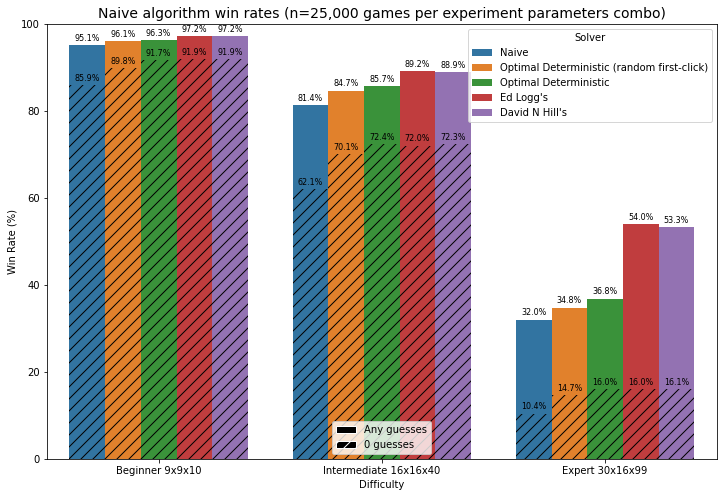

In [26]:
order = ['Naive', 'Optimal Deterministic (random first-click)', 'Optimal Deterministic', "Ed Logg's", "David N Hill's"]

# Plot two barplots, one on top of the other
sns.barplot(x='difficulty', y='win_rate', hue='solver', hue_order=order, data=df_compare)
g = sns.barplot(x='difficulty', y='win_rate_0_guess', hue='solver', hue_order=order, data=df_compare, hatch='//')


# Y axis should have exact range [0, 100]
g.set_ylim(0, 100)

# Labels
g.set_xlabel('Difficulty')
g.set_ylabel('Win Rate (%)')
g.set_title("Naive algorithm win rates (n=25,000 games per experiment parameters combo)", fontsize=14)

# Annotate each bar with its percentage value
for p in g.patches:
    g.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
     ha='center', va='center', fontsize=8, color='black', xytext=(0, 7),
         textcoords='offset points')

# Resize figure
fig = plt.gcf()
fig.set_size_inches(12, 8)

# Get/create patches (coloured boxes to display in legend)
patches = g.legend_.get_patches()[:5]
patch1 = Patch(facecolor='k', edgecolor='w')
patch2 = Patch(facecolor='k', edgecolor='w', hatch='//')

# Add both legends
legend1 = plt.legend([patch1, patch2], ["Any guesses", "0 guesses"], loc=8)
plt.legend(title="Solver", handles=patches, labels=order, loc=1)
plt.gca().add_artist(legend1)


plt.show()

In [28]:
order = ['Naive', 'Optimal Deterministic (random first-click)', 'Optimal Deterministic', "Ed Logg's", "David N Hill's"]
sns.barplot(x='difficulty', y='win_rate', hue='solver', hue_order=order, data=df_compare_solvers)
sns.barplot(x='difficulty', y='win_rate_0_guess', hue='solver', hue_order=order, data=df_compare_solvers)

fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

ValueError: Could not interpret input 'win_rate'

## Other

In [44]:
sns.set_theme()

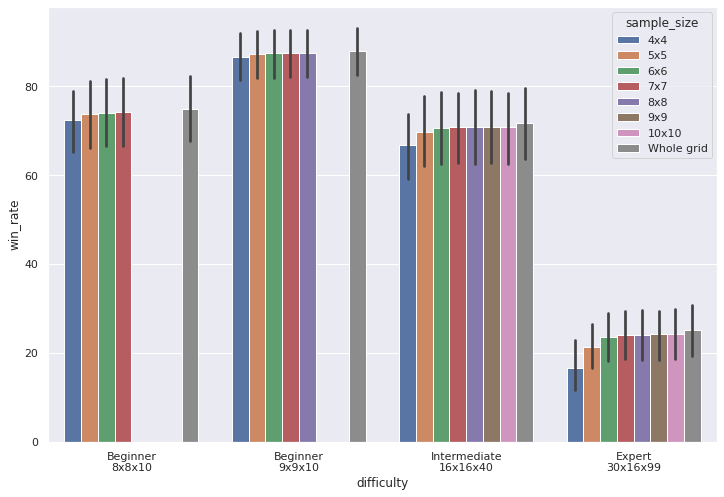

In [45]:
sample_size_order = ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid']

sns.barplot(x='difficulty', y='win_rate', hue='sample_size', hue_order=sample_size_order, data=df_wins)

fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

In [46]:
# sns.set_theme()

# sample_size_order = ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid']


# # plt.xticks(rotation=315)
# g = sns.catplot(data=df_pt, col='first_click_always_zero', row="use_mine_count",
#                 x='difficulty_and_flag_ability', y='win_rate', hue='sample_size',
#                 kind='bar', hue_order=sample_size_order, sharex=False, sharey=False)

# fig = plt.gcf()
# fig.set_size_inches(42, 12)

# g.set_xlabels("Difficulty & Can Agent Flag")
# g.set_ylabels("Win Rate (%)")

# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('The overal win rates, measured for each combination of experiment parameters (n=15,000 games per combo)',
#               fontsize=24)

# # Reduce horizontal gap between facets
# plt.subplots_adjust(wspace=0.05)

# # Y-axis range limit for all plots
# for row in g.axes:
#     for ax in row:
#         ax.set_ylim(0, 100)


# plt.show()

### Main win rates (across all experiment combinations)

In [47]:
def plot_main_win_rates_group(df, title=None, annotate=True, size_inches=(20, 8), legend=True):
    sample_size_order = ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid']
        
    # Plot two barplots, one on top of the other
    sns.barplot(x='difficulty', y='win_rate', hue='sample_size', hue_order=sample_size_order, data=df)
    g = sns.barplot(x='difficulty', y='win_rate_0_guess', hue='sample_size', data=df, hue_order=sample_size_order, hatch='//')
    
    # Y axis should have exact range [0, 100]
    g.set_ylim(0, 100)
    
    # Labels
    g.set_xlabel('Difficulty')
    g.set_ylabel('Win Rate (%)')
    g.set_title(title, fontsize=14)
    
    if annotate:
        # Annotate each bar with its percentage value
        for p in g.patches:
            g.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
             ha='center', va='center', fontsize=8, color='black', xytext=(0, 7),
             textcoords='offset points')

    # Resize figure
    fig = plt.gcf()
    fig.set_size_inches(*size_inches)
    
    if legend:
        # Get/create patches (coloured boxes to display in legend)
        patches = g.legend_.get_patches()[:8]
        patch1 = Patch(facecolor='k', edgecolor='w')
        patch2 = Patch(facecolor='k', edgecolor='w', hatch='//')

        # Add both legends
        legend1 = plt.legend([patch1, patch2], ["Any guesses", "0 guesses"], loc=2)
        plt.legend(title="Sample Size", handles=patches, labels=['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid'], loc=1)
        plt.gca().add_artist(legend1)
    else:
        plt.legend([])


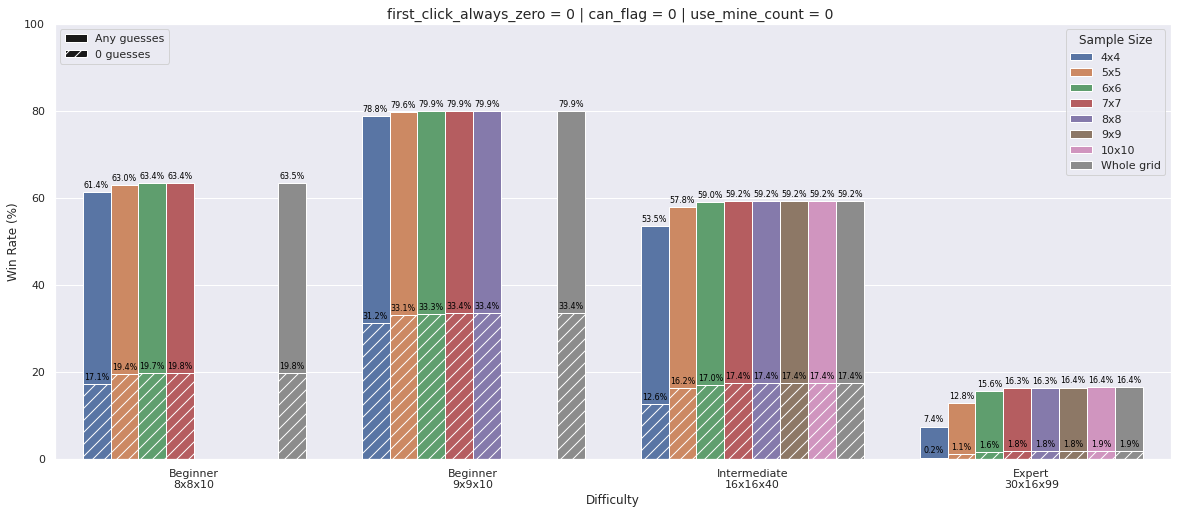

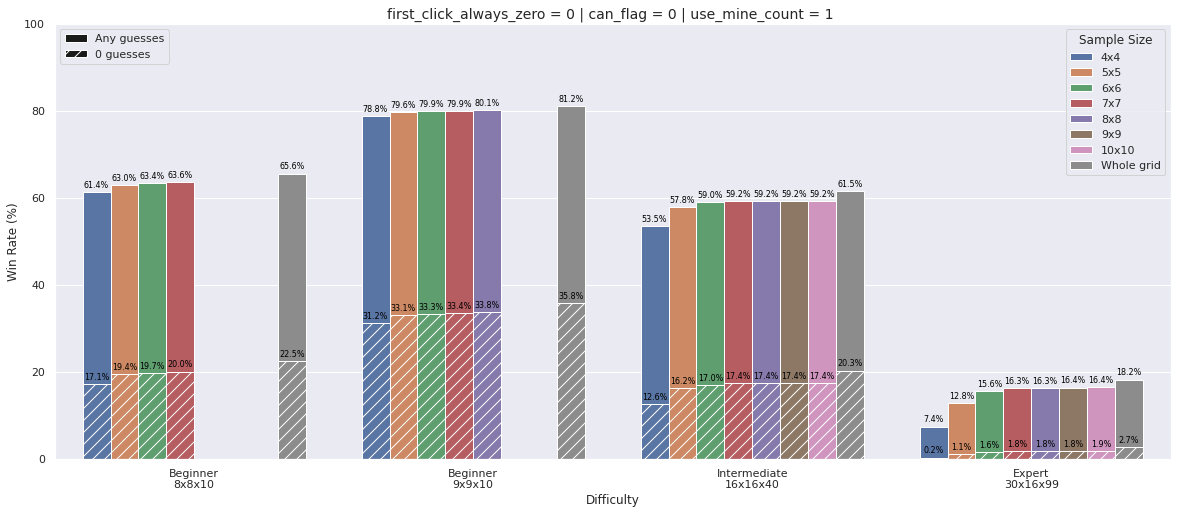

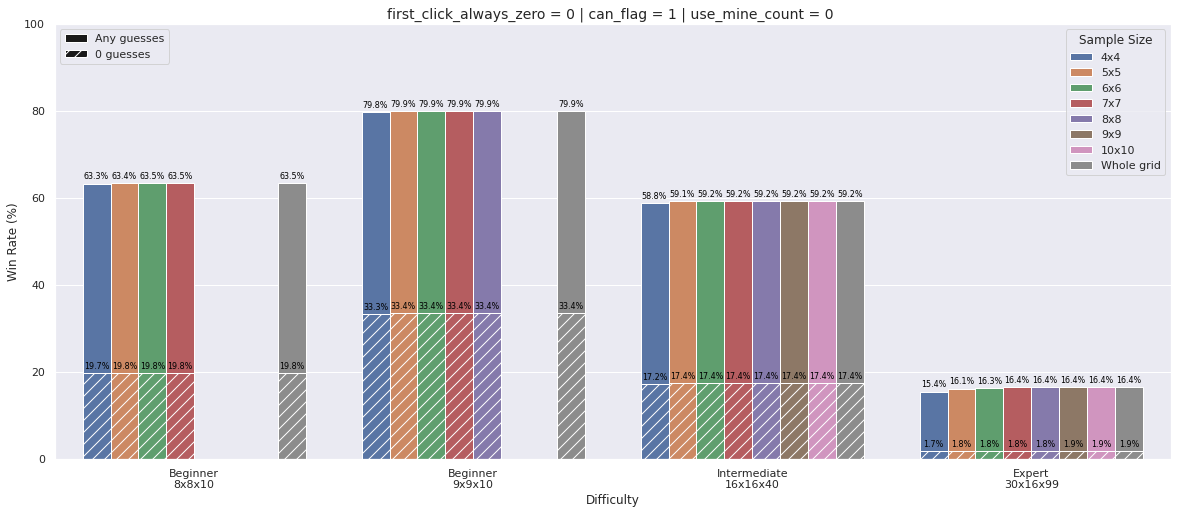

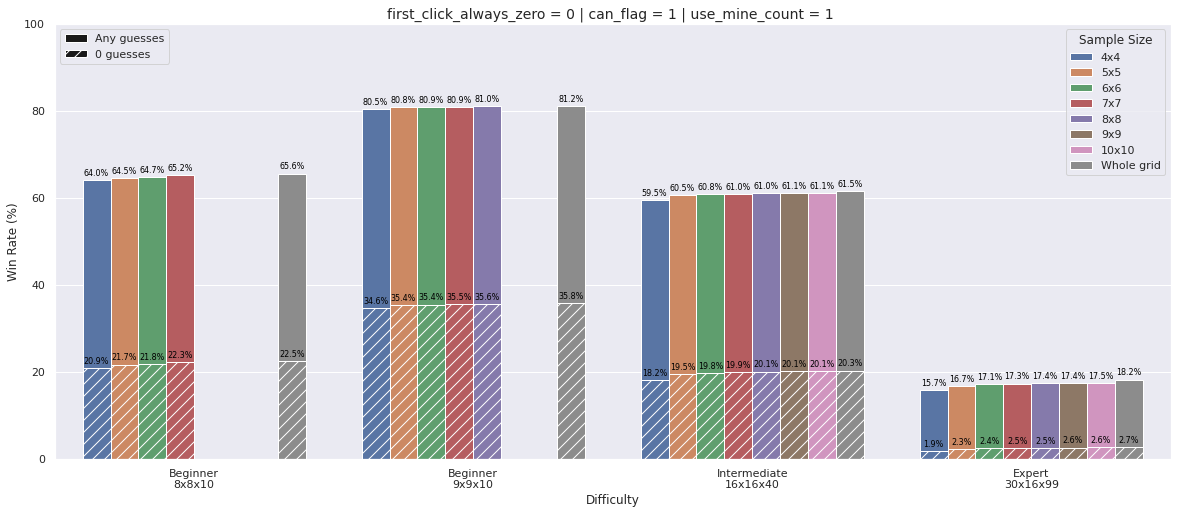

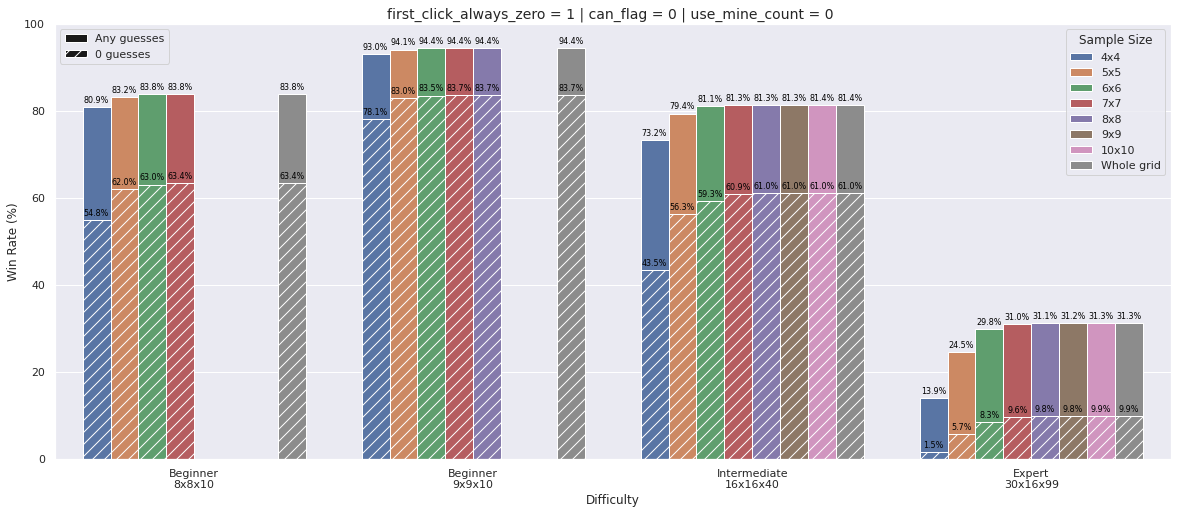

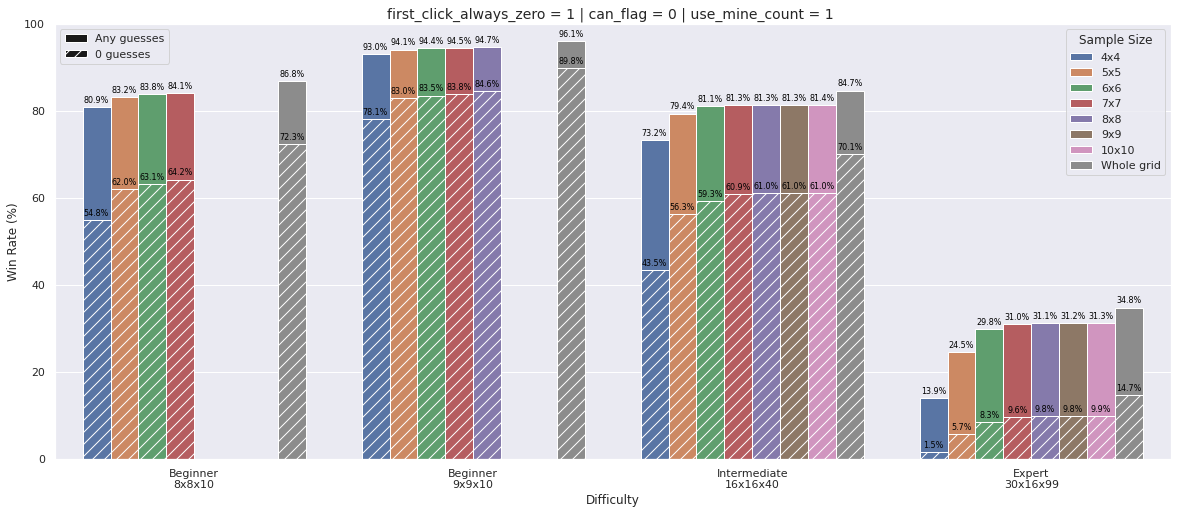

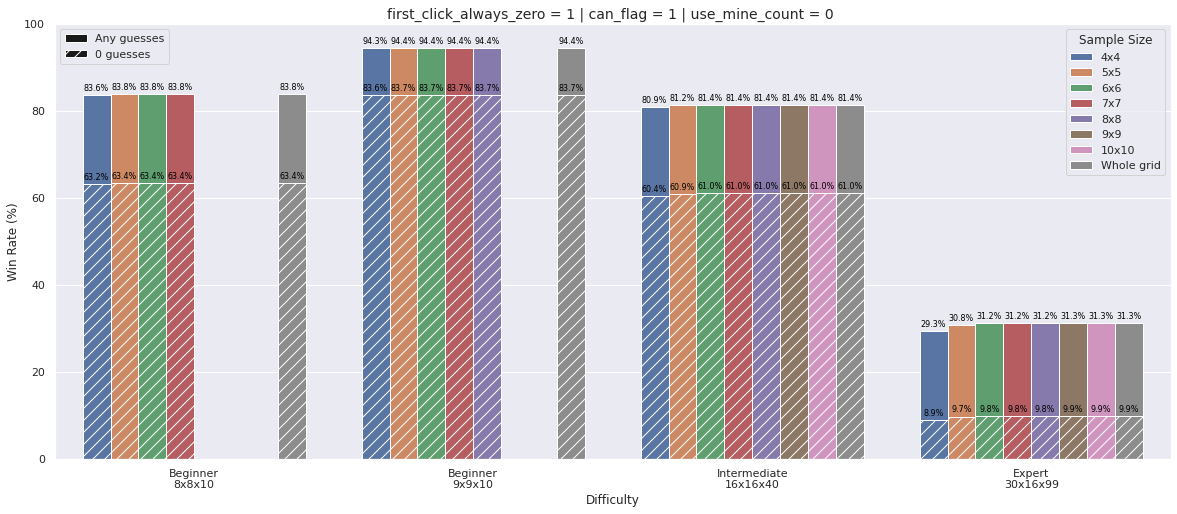

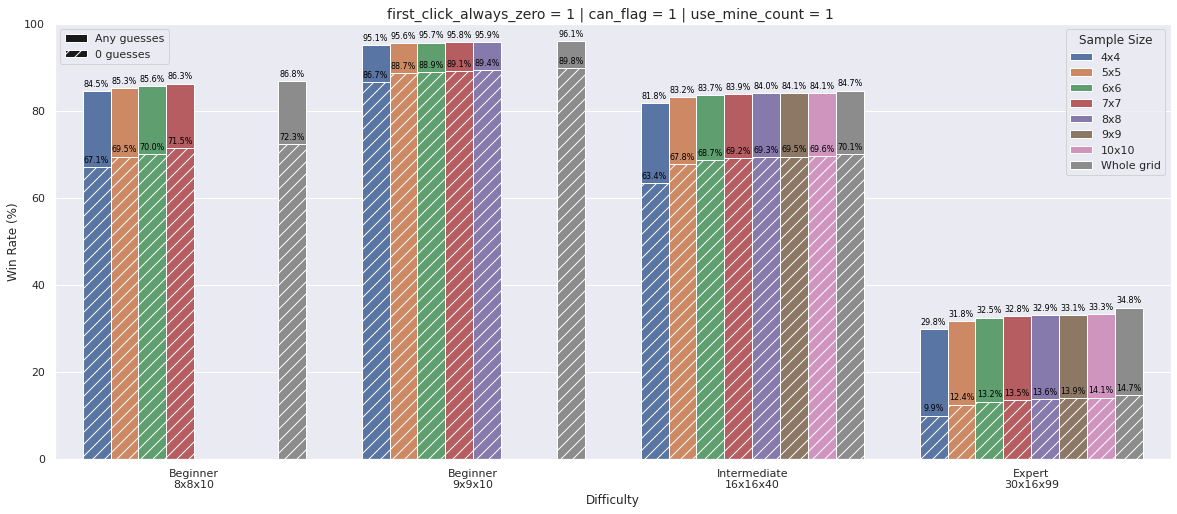

In [48]:
variables = ['first_click_always_zero', 'can_flag', 'use_mine_count']
groupby = df_wins.groupby(variables)

for (i, (key, group)) in enumerate(groupby):
    title = ""
    for (variable, boolean) in zip(variables, key):
        title += f'{variable} = {boolean} | '
    
    title = title[:-2]
    
    plot_main_win_rates_group(group, title)
    plt.savefig(f'main_win_rates_{i}.png', dpi=200)
    plt.show()
    

### Main win rates (leaving in one variable)

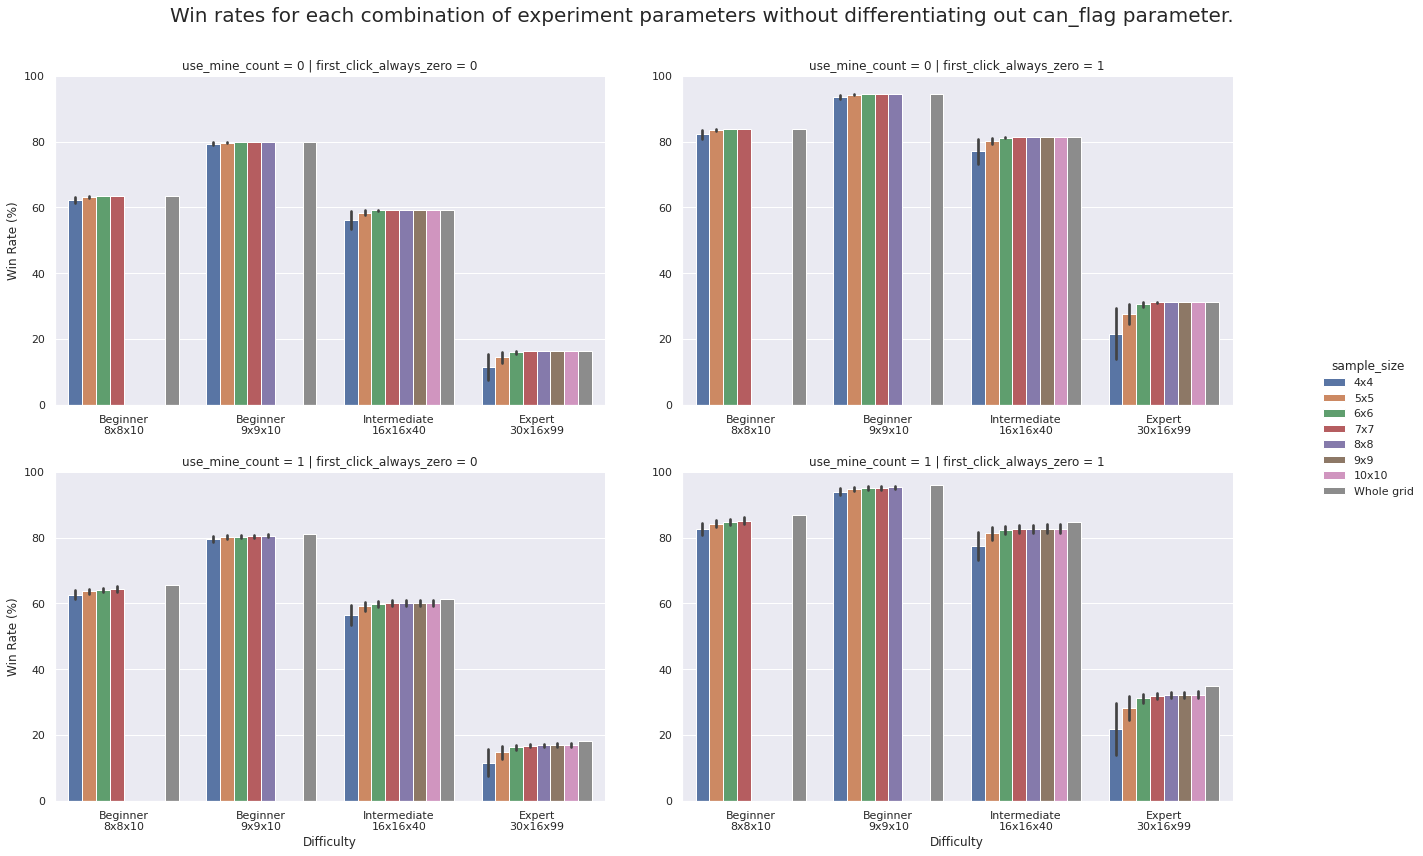

In [49]:
sample_size_order = ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid']
g = sns.catplot(data=df_wins, col='first_click_always_zero', row="use_mine_count",
                x='difficulty', y='win_rate', hue='sample_size', kind='bar', hue_order=sample_size_order,
                sharex=False, sharey=False)

g.set_xlabels("Difficulty")
g.set_ylabels("Win Rate (%)")

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Win rates for each combination of experiment parameters without differentiating out can_flag parameter.',
              fontsize=20)

# Y-axis range limit for all plots
for row in g.axes:
    for ax in row:
        ax.set_ylim(0, 100)


fig = plt.gcf()
fig.set_size_inches(20, 12)
plt.show()

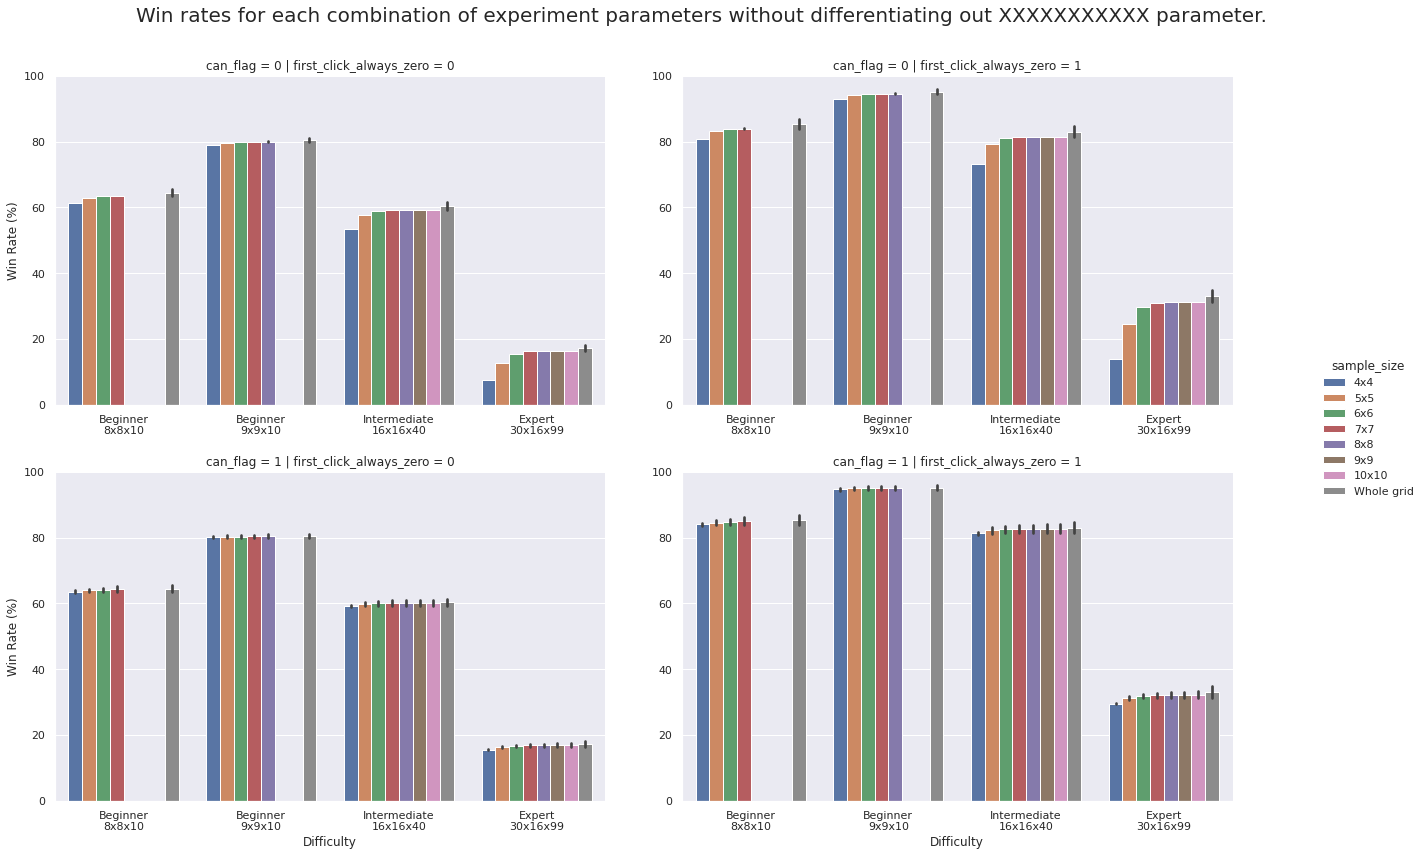

In [50]:
sample_size_order = ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid']
g = sns.catplot(data=df_wins, col='first_click_always_zero', row="can_flag",
                x='difficulty', y='win_rate', hue='sample_size', kind='bar', hue_order=sample_size_order,
                sharex=False, sharey=False)

g.set_xlabels("Difficulty")
g.set_ylabels("Win Rate (%)")

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Win rates for each combination of experiment parameters without differentiating out XXXXXXXXXXX parameter.',
              fontsize=20)

# Y-axis range limit for all plots
for row in g.axes:
    for ax in row:
        ax.set_ylim(0, 100)


fig = plt.gcf()
fig.set_size_inches(20, 12)
plt.show()

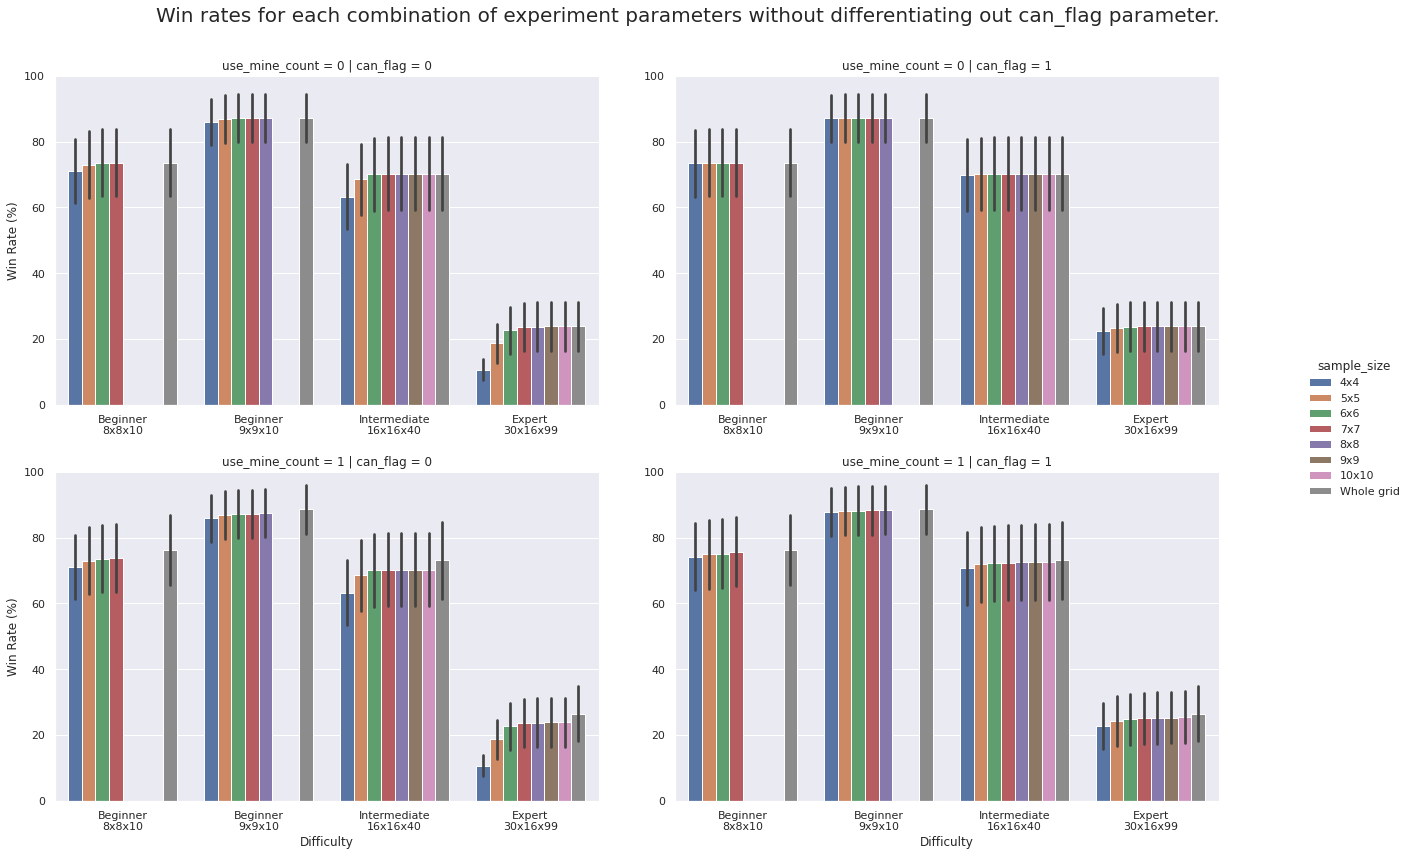

In [51]:
sample_size_order = ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid']
g = sns.catplot(data=df_wins, col='can_flag', row="use_mine_count",
                x='difficulty', y='win_rate', hue='sample_size', kind='bar', hue_order=sample_size_order,
                sharex=False, sharey=False)

g.set_xlabels("Difficulty")
g.set_ylabels("Win Rate (%)")

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Win rates for each combination of experiment parameters without differentiating out can_flag parameter.',
              fontsize=20)

# Y-axis range limit for all plots
for row in g.axes:
    for ax in row:
        ax.set_ylim(0, 100)


fig = plt.gcf()
fig.set_size_inches(20, 12)
plt.show()

In [52]:
df2 = df_wins[(df_wins['first_click_always_zero'] == True)]
df2

,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games,difficulty,sample_size,win_rate,win_rate_0_guess
0,4,4,0,1,1,9475,12544,15000,Beginner\n8x8x10,4x4,83.63,63.17
1,4,4,1,1,1,10070,12683,15000,Beginner\n8x8x10,4x4,84.55,67.13
3,5,5,1,1,1,10422,12798,15000,Beginner\n8x8x10,5x5,85.32,69.48
6,5,5,0,1,1,9508,12567,15000,Beginner\n8x8x10,5x5,83.78,63.39
8,6,6,1,1,1,10498,12842,15000,Beginner\n8x8x10,6x6,85.61,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...
211,32,18,0,1,0,1479,4691,15000,Expert\n30x16x99,Whole grid,31.27,9.86
212,9,9,1,1,0,1475,4683,15000,Expert\n30x16x99,9x9,31.22,9.83
213,32,18,1,1,0,2199,5213,15000,Expert\n30x16x99,Whole grid,34.75,14.66
214,10,10,0,1,0,1479,4690,15000,Expert\n30x16x99,10x10,31.27,9.86


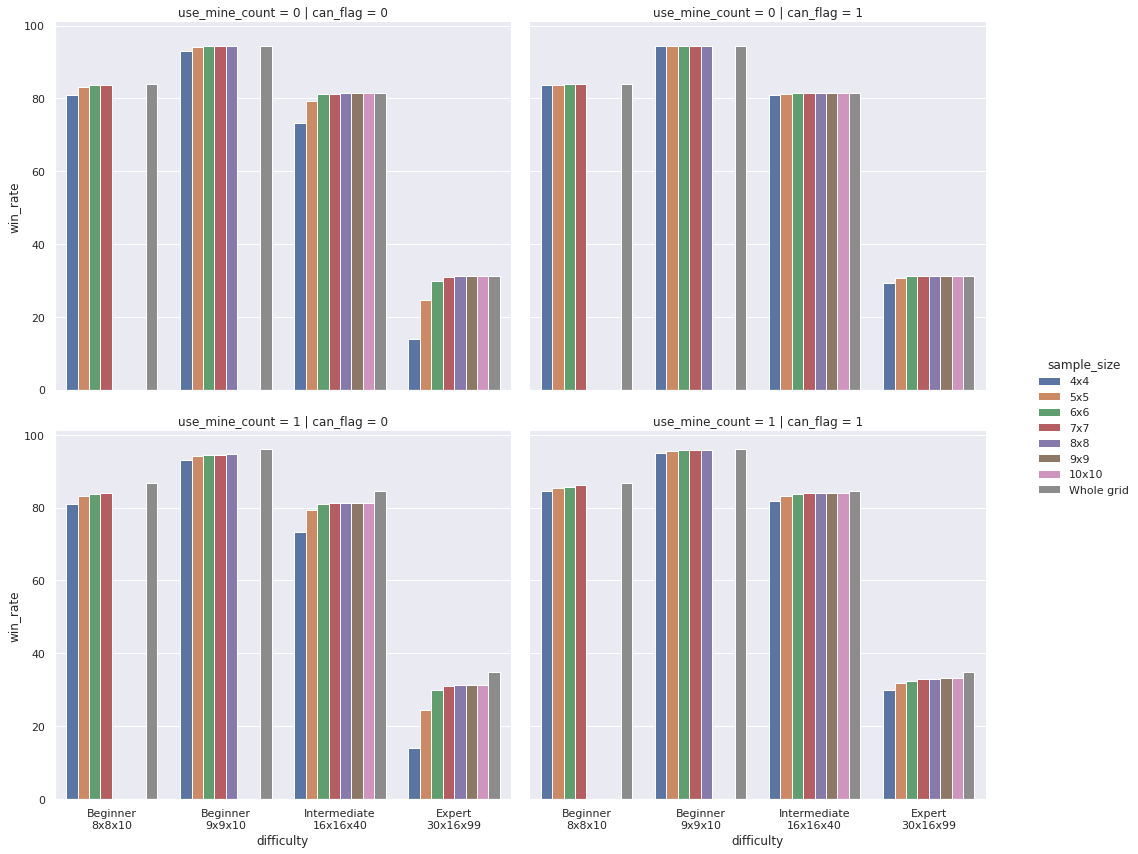

In [53]:
sample_size_order = ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid']
g = sns.catplot(data=df2, col='can_flag', row="use_mine_count",
                x='difficulty', y='win_rate', hue='sample_size', kind='bar', hue_order=sample_size_order)
# g.map_dataframe(sns.scatterplot, x="difficulty")

fig = plt.gcf()
fig.set_size_inches(16, 12)
plt.show()

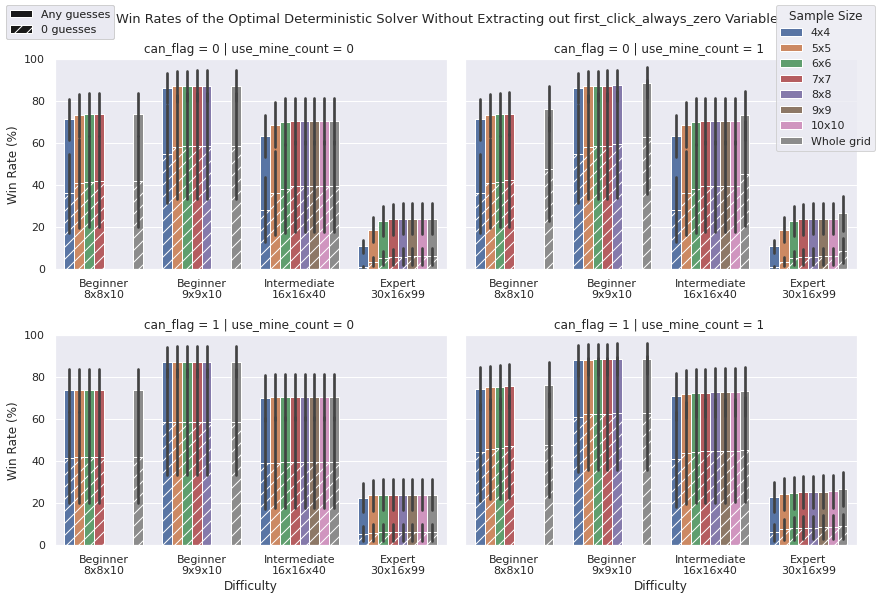

In [54]:
# Initialise the figure and a subplot axes. Each subplot sharing (showing) the
# same range of values for the x and y axis in the plots.
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=True)
fig.tight_layout(h_pad=4, w_pad=0.1)

variables = ['first_click_always_zero', 'can_flag', 'use_mine_count']

var_to_omit = 'first_click_always_zero'
variables.remove(var_to_omit)

# Set the title for the figure
fig.suptitle(f'Win Rates of the Optimal Deterministic Solver Without Extracting out {var_to_omit} Variable', fontsize=13)
plt.subplots_adjust(top=0.9)

groupby = df_wins.groupby(variables)

# for (i, (key, group)) in enumerate(groupby):
#     title = ""
#     for (variable, boolean) in zip(variables, key):
#         title += f'{variable} = {boolean} | '
    
#     title = title[:-2]
    
#     plot_main_win_rates_group(group, title)
#     plt.savefig(f'main_win_rates_{i}.png', dpi=400)
#     plt.show()

for (i, (key, group)) in enumerate(groupby):
#     print(group)
    title = ""
    for (variable, boolean) in zip(variables, key):
        title += f'{variable} = {boolean} | '
    
    title = title[:-2]
    
    ax = axes[key[0], key[1]]
    ax.set_title(title)
    
    
    sample_size_order = ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid']
    
          
    # Plot two barplots, one on top of the other
    sns.barplot(ax=ax, x='difficulty', y='win_rate', hue='sample_size', hue_order=sample_size_order, data=group)
    g = sns.barplot(ax=ax, x='difficulty', y='win_rate_0_guess', hue='sample_size', hue_order=sample_size_order, data=group, hatch='//')
    
    # Y axis should have exact range [0, 100]
    g.set_ylim(0, 100)
    
    
    # Labels
    g.set_title(title, fontsize=12)
    g.set_xlabel('')
    g.set_ylabel('')
    
    if key[0] == 1:
        g.set_xlabel('Difficulty')
    if key[1] == 0:
        g.set_ylabel('Win Rate (%)')
    
    
#     if annotate:
#         # Annotate each bar with its percentage value
#         for p in g.patches:
#             g.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
#              ha='center', va='center', fontsize=8, color='black', xytext=(0, 7),
#              textcoords='offset points')
    
#     g = sns.barplot(ax=ax, x='difficulty', y='win_rate', hue='sample_size', hue_order=sample_size_order, data=group)
    patches = g.legend_.get_patches()[:8]
    g.get_legend().remove()
    
# Get/create patches (coloured boxes to display in legend)
patch1 = Patch(facecolor='k', edgecolor='w')
patch2 = Patch(facecolor='k', edgecolor='w', hatch='//')

# Add both legends
legend1 = fig.legend([patch1, patch2], ["Any guesses", "0 guesses"], loc=2)
fig.legend(title="Sample Size", handles=patches, labels=['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid'], loc=1)
fig.add_artist(legend1)
  
#     plot_main_win_rates_group(group, title)
#     plt.savefig(f'main_win_rates_{i}.png', dpi=400)
#     plt.show()

plt.show()


In [55]:
df2_copy = df2.copy()
df2_copy = df2_copy[::-1]
df2_copy = df2_copy.reset_index()
df2_copy

,index,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games,difficulty,sample_size,win_rate,win_rate_0_guess
0,215,10,10,1,1,0,1479,4690,15000,Expert\n30x16x99,10x10,31.27,9.86
1,214,10,10,0,1,0,1479,4690,15000,Expert\n30x16x99,10x10,31.27,9.86
2,213,32,18,1,1,0,2199,5213,15000,Expert\n30x16x99,Whole grid,34.75,14.66
3,212,9,9,1,1,0,1475,4683,15000,Expert\n30x16x99,9x9,31.22,9.83
4,211,32,18,0,1,0,1479,4691,15000,Expert\n30x16x99,Whole grid,31.27,9.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,8,6,6,1,1,1,10498,12842,15000,Beginner\n8x8x10,6x6,85.61,69.99
104,6,5,5,0,1,1,9508,12567,15000,Beginner\n8x8x10,5x5,83.78,63.39
105,3,5,5,1,1,1,10422,12798,15000,Beginner\n8x8x10,5x5,85.32,69.48
106,1,4,4,1,1,1,10070,12683,15000,Beginner\n8x8x10,4x4,84.55,67.13


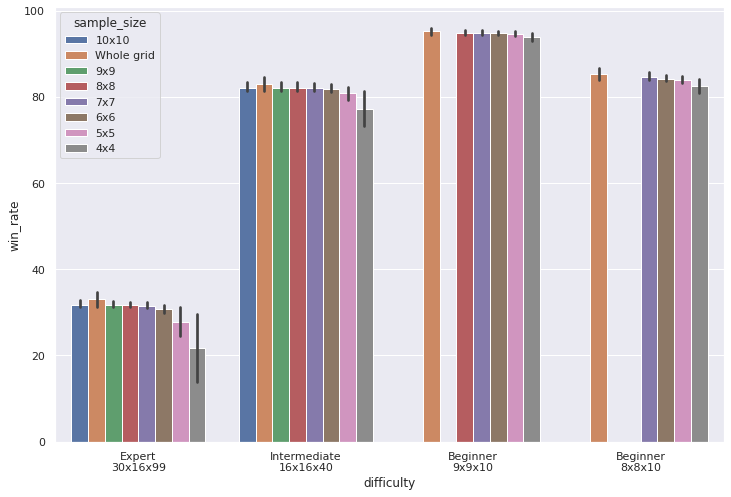

In [56]:
sample_size_order = ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10', 'Whole grid']
# sample_size_order = ['4x4', '5x5', '6x6', 'Whole grid']

# sns.barplot(x='difficulty', y='win_rate', hue='sample_size', hue_order=sample_size_order, data=df2_copy)
# sns.barplot(x='difficulty', y='win_rate', hue='sample_size', order=x_order, data=df2)
sns.barplot(x='difficulty', y='win_rate', hue='sample_size', data=df2_copy)
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

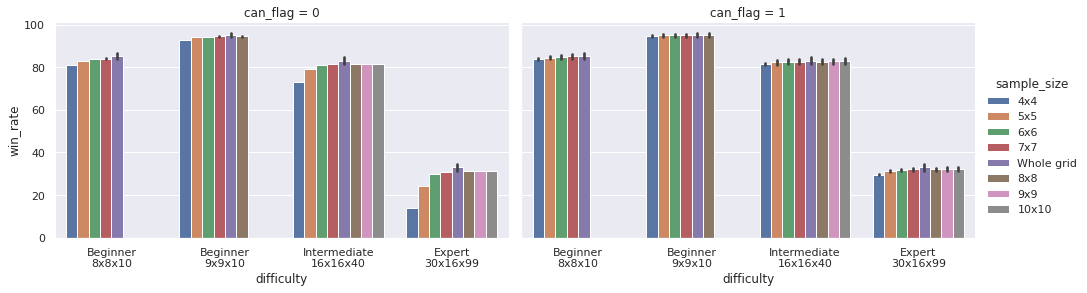

In [57]:
sns.catplot(x="difficulty", y="win_rate", hue="sample_size", col="can_flag", data=df2, kind="bar", height=4, aspect=1.7);

### Proof that can_flag makes no difference on whole-grid samples
Notice how the wins stay exactly the same when differentiating beteween whether agent can flag or cannot.

In [68]:
df = df_wins[(df_wins['use_mine_count'] == True) & (df_wins['first_click_always_zero'] == True) & (df_wins['sample_size'] == 'Whole grid')]
df

,sample_width,sample_height,use_mine_count,first_click_always_zero,can_flag,wins_0_guess,wins,num_games,difficulty,sample_size,win_rate,win_rate_0_guess
16,10,10,1,1,1,10845,13022,15000,Beginner\n8x8x10,Whole grid,86.81,72.30
36,10,10,1,1,0,10845,13022,15000,Beginner\n8x8x10,Whole grid,86.81,72.30
50,11,11,1,1,1,13463,14413,15000,Beginner\n9x9x10,Whole grid,96.09,89.75
62,11,11,1,1,0,13463,14413,15000,Beginner\n9x9x10,Whole grid,96.09,89.75
102,18,18,1,1,1,10521,12698,15000,Intermediate\n16x16x40,Whole grid,84.65,70.14
118,18,18,1,1,0,10521,12698,15000,Intermediate\n16x16x40,Whole grid,84.65,70.14
197,32,18,1,1,1,2199,5213,15000,Expert\n30x16x99,Whole grid,34.75,14.66
213,32,18,1,1,0,2199,5213,15000,Expert\n30x16x99,Whole grid,34.75,14.66
